In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
# RescueNet
RESCUE_IMG_DIR = '/kaggle/input/rescuenet/RescueNet/train/train-org-img'
RESCUE_MASK_DIR = '/kaggle/input/rescuenet/RescueNet/train/train-label-img'
RESCUE_VAL_IMG_DIR = '/kaggle/input/rescuenet/RescueNet/val/val-org-img'
RESCUE_VAL_MASK_DIR = '/kaggle/input/rescuenet/RescueNet/val/val-label-img'

# xView2
XVIEW_IMG_DIR = '/kaggle/input/xview2-challenge-dataset-tier-3-data/tier3/images'
XVIEW_MASK_DIR = '/kaggle/input/xview2-challenge-dataset-tier-3-data/tier3/labels'


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_ext='.jpg', mask_ext='.png', mask_suffix='', transform=None):
        img_files = [f for f in os.listdir(img_dir) if f.endswith(img_ext)]
        mask_files = [f for f in os.listdir(mask_dir) if f.endswith(mask_ext)]
        img_bases = {os.path.splitext(f)[0] for f in img_files}
        mask_bases = {os.path.splitext(f)[0].replace(mask_suffix, '') for f in mask_files}
        common_bases = sorted(list(img_bases.intersection(mask_bases)))
        self.img_paths = [os.path.join(img_dir, base + img_ext) for base in common_bases]
        self.mask_paths = [os.path.join(mask_dir, base + mask_suffix + mask_ext) for base in common_bases]
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])
        image = np.array(image)
        mask = np.array(mask)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask.long()


In [5]:
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2(),
])

# RescueNet
rescue_train = SegmentationDataset(RESCUE_IMG_DIR, RESCUE_MASK_DIR, img_ext='.jpg', mask_ext='.png', mask_suffix='_lab', transform=train_transform)
rescue_val = SegmentationDataset(RESCUE_VAL_IMG_DIR, RESCUE_VAL_MASK_DIR, img_ext='.jpg', mask_ext='.png', mask_suffix='_lab', transform=val_transform)

# xView2 (adjust mask_suffix/mask_ext if needed)
xview_train = SegmentationDataset(XVIEW_IMG_DIR, XVIEW_MASK_DIR, img_ext='.png', mask_ext='.png', mask_suffix='', transform=train_transform)

# Combine datasets for training
from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([rescue_train, xview_train])
val_dataset = rescue_val

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


In [6]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: 

In [6]:
import segmentation_models_pytorch as smp
num_classes = 11  
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [7]:

class_weights = torch.tensor([1.0, 2.0, 5.0, 10.0, 15.0, 15.0, 2.0, 2.0, 5.0, 2.0, 2.0], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


In [10]:
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=11)


In [11]:
images, masks = next(iter(train_loader))
print(torch.unique(masks))


tensor([ 0,  1,  2,  5,  6,  9, 11])


In [12]:
from sklearn.metrics import f1_score
import gc
num_epochs = 20
best_f1 = 0
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for images, masks in train_loader:
        masks[masks==11]=0
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1} training loss: {np.mean(train_losses):.4f}")
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)
    class_f1s = f1_score(all_masks.flatten(), all_preds.flatten(), average=None, labels=list(range(num_classes)))
    macro_f1 = np.mean(class_f1s)
    print(f"Epoch {epoch+1} Validation Class-wise F1: {class_f1s}")
    print(f"Epoch {epoch+1} Validation Macro F1: {macro_f1:.4f}")
    scheduler.step(macro_f1)
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), 'best_damage_model.pth')
        print(f"Saved best model with Macro F1: {best_f1:.4f}")
    torch.cuda.empty_cache()
    gc.collect()


Epoch 1 training loss: 1.4562
Epoch 1 Validation Class-wise F1: [0.04455486 0.43453404 0.6887196  0.40976062 0.24569241 0.08596253
 0.         0.         0.38886345 0.73256337 0.        ]
Epoch 1 Validation Macro F1: 0.2755
Saved best model with Macro F1: 0.2755
Epoch 2 training loss: 1.2083
Epoch 2 Validation Class-wise F1: [0.10880416 0.52051775 0.78122916 0.50662484 0.26745481 0.28241206
 0.         0.         0.6034537  0.37557332 0.        ]
Epoch 2 Validation Macro F1: 0.3133
Saved best model with Macro F1: 0.3133
Epoch 3 training loss: 1.0836
Epoch 3 Validation Class-wise F1: [0.05773172 0.62645866 0.76945415 0.57665745 0.40685452 0.25027941
 0.         0.         0.65474492 0.82993377 0.        ]
Epoch 3 Validation Macro F1: 0.3793
Saved best model with Macro F1: 0.3793
Epoch 4 training loss: 1.0265
Epoch 4 Validation Class-wise F1: [0.1077007  0.63545774 0.75764423 0.59779784 0.32573011 0.29183477
 0.         0.         0.72732671 0.82709111 0.        ]
Epoch 4 Validation Macr

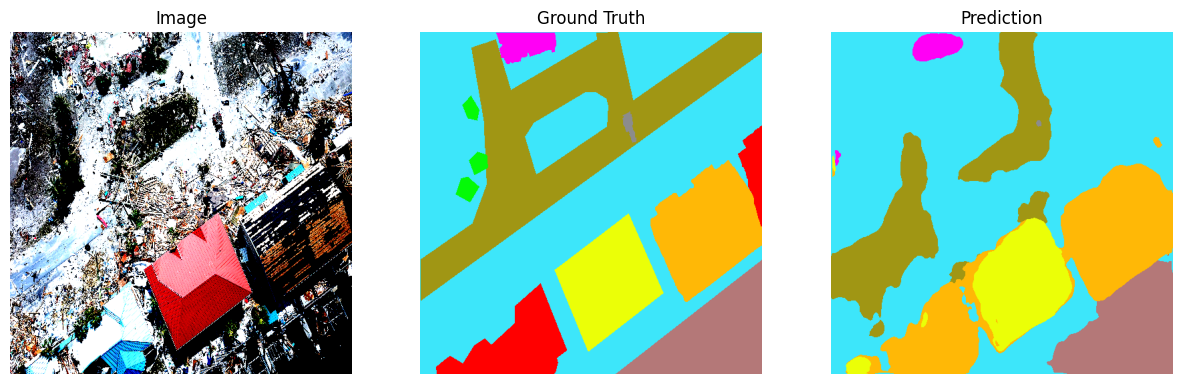

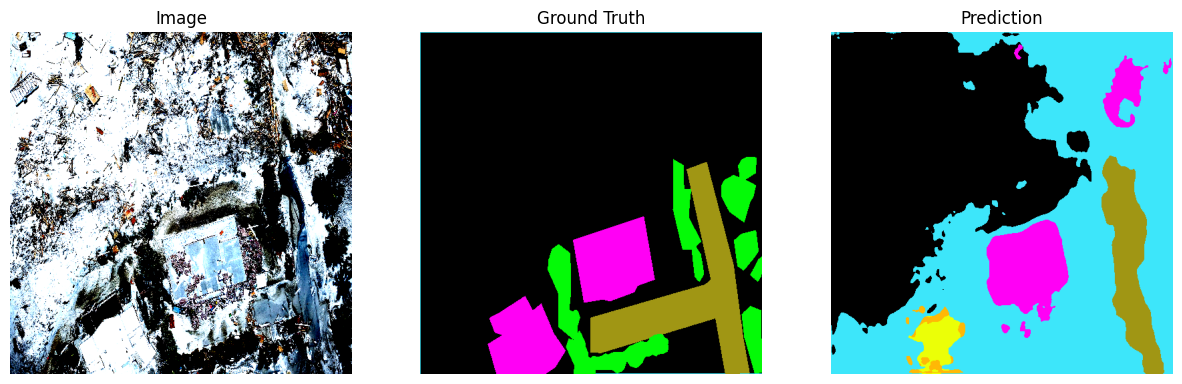

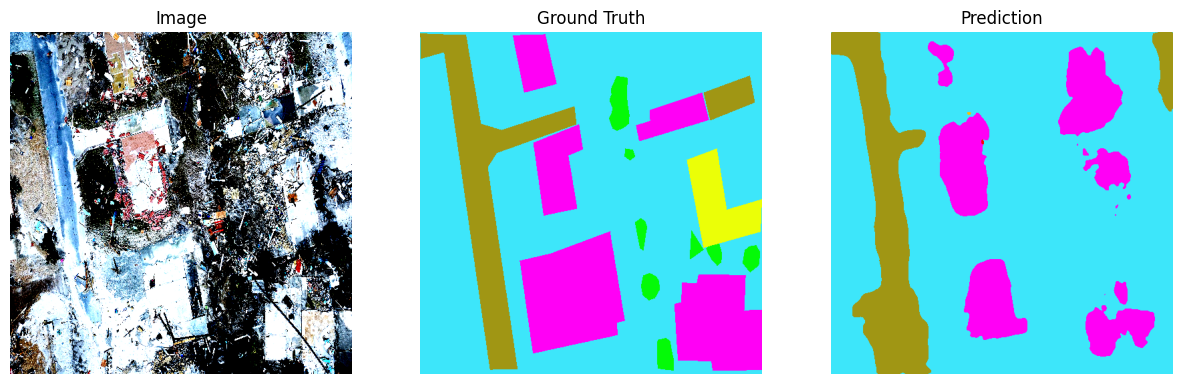

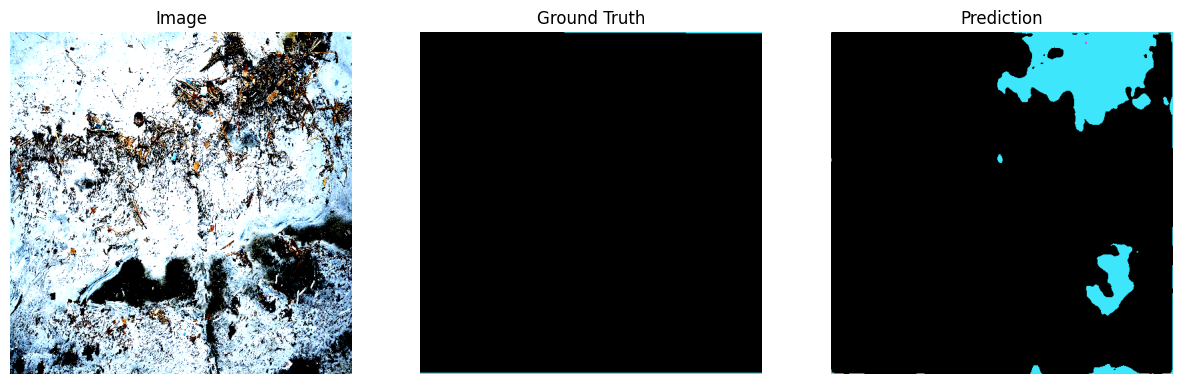

In [13]:
import matplotlib.pyplot as plt
import torch

# Load your best model
model.load_state_dict(torch.load('best_damage_model.pth'))
model.eval()

# Get a batch from the validation loader
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Define class names and colors for visualization
class_names = [
    'Background', 'Water', 'Building No Damage', 'Building Minor Damage',
    'Building Major Damage', 'Building Total Destruction', 'Vehicle',
    'Road-Clear', 'Road-Blocked', 'Tree', 'Pool'
]
colors = [
    (0,0,0), (61,230,250), (180,120,120), (235,255,7), (255,184,6), (255,0,0),
    (255,0,245), (140,140,140), (160,150,20), (4,250,7), (255,235,0)
]

# Function to colorize mask for visualization
import numpy as np

def colorize_mask(mask):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for idx, color in enumerate(colors):
        color_mask[mask == idx] = color
    return color_mask

# Visualize a few samples
for i in range(min(4, len(images))):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(colorize_mask(masks[i].cpu().numpy()))
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(colorize_mask(preds[i]))
    plt.title('Prediction')
    plt.axis('off')
    plt.show()


In [15]:
remap_dict = {2: 1, 3: 2, 4: 3, 5: 4}  
mask_remapped = np.zeros_like(masks)
for orig, new in remap_dict.items():
    mask_remapped[masks == orig] = new
# All other pixels remain 0 (background)


In [22]:
import segmentation_models_pytorch as smp
num_classes = 5  # [background, no damage, minor, major, total destruction]
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
)
model = model.to(device)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, ignore_index=None):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.ignore_index = ignore_index
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, ignore_index=self.ignore_index, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.ignore_index is not None:
            mask = (targets != self.ignore_index)
            focal_loss = focal_loss[mask]
        return focal_loss.mean()

class_weights = torch.tensor([1.0, 1.0, 2.0, 3.0, 3.0], device=device)  # [bg, no, minor, major, total]
criterion = FocalLoss(weight=class_weights, gamma=2, ignore_index=None)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    # Replace the box predictor head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # Replace the mask predictor head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

num_classes = 5  # [background, no damage, minor, major, total destruction]
model = get_model_instance_segmentation(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [36]:
import torch
import numpy as np
from torchvision.ops import masks_to_boxes


semantic_mask = np.array([[0, 1, 0, 2], [2, 0, 3, 3], [0, 0, 0, 0]])  # Example shape [H, W]

# Convert to torch tensor
mask_tensor = torch.as_tensor(semantic_mask, dtype=torch.int64)

# Get unique object ids
obj_ids = torch.unique(mask_tensor)
obj_ids = obj_ids[obj_ids != 0]  # remove background

# Split the mask into a set of boolean masks, one per instance
masks = (mask_tensor == obj_ids[:, None, None])  # shape [N, H, W], boolean
masks = masks.to(torch.uint8)

# Remove empty masks
valid_mask_indices = masks.sum(dim=(1,2)) > 0
masks = masks[valid_mask_indices]
obj_ids = obj_ids[valid_mask_indices]

# Get bounding boxes for each mask
boxes = masks_to_boxes(masks)  # shape [N, 4], format: [xmin, ymin, xmax, ymax]

print('masks shape:', masks.shape)  # [N, H, W]
print('boxes shape:', boxes.shape)  # [N, 4]


masks shape: torch.Size([3, 3, 4])
boxes shape: torch.Size([3, 4])


In [42]:
import torch
import numpy as np
from torchvision.ops import masks_to_boxes



semantic_mask = np.array([[0, 1, 0, 2], [2, 0, 3, 3], [0, 0, 0, 0]])  # shape [H, W]
damage_labels = [1, 2, 3]  

mask_tensor = torch.as_tensor(semantic_mask, dtype=torch.int64)
obj_ids = torch.unique(mask_tensor)
obj_ids = obj_ids[obj_ids != 0]  # remove background


masks = (mask_tensor == obj_ids[:, None, None])  # shape [N, H, W]
masks = masks.to(torch.uint8)


valid_mask_indices = masks.sum(dim=(1,2)) > 0
masks = masks[valid_mask_indices]
obj_ids = obj_ids[valid_mask_indices]

# Get bounding boxes for each mask
boxes = masks_to_boxes(masks)  # shape [N, 4]


labels = torch.tensor(damage_labels, dtype=torch.int64)  # shape [N]


# (replace semantic_mask and damage_labels with your actual data)
target = {
    'boxes': boxes,      # [N, 4] torch.FloatTensor
    'labels': labels,    # [N] torch.Int64Tensor
    'masks': masks       # [N, H, W] torch.UInt8Tensor
}


In [1]:
class BuildingDamageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, damage_labels_list):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.damage_labels_list = damage_labels_list
    def __getitem__(self, idx):
        image =  # Load image as torch tensor, shape [3, H, W]
        semantic_mask =  # Load mask as numpy array, shape [H, W]
        damage_labels = self.damage_labels_list[idx] # List of length N
        mask_tensor = torch.as_tensor(semantic_mask, dtype=torch.int64)
        obj_ids = torch.unique(mask_tensor)
        obj_ids = obj_ids[obj_ids != 0]
        masks = (mask_tensor == obj_ids[:, None, None]).to(torch.uint8)
        valid_mask_indices = masks.sum(dim=(1,2)) > 0
        masks = masks[valid_mask_indices]
        obj_ids = obj_ids[valid_mask_indices]
        boxes = masks_to_boxes(masks)
        labels = torch.tensor(damage_labels, dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks
        }
        return image, target
    def __len__(self):
        return len(self.image_paths)


NameError: name 'torch' is not defined